
# **CREDIT CARD FRAUD DETECTION PROJECT - MODEL TRAINING AND EVALUATION**


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

#### **APPLY FEATURE SCALING ON TEST DATA**

In [52]:
# Load the test data
test_df = pd.read_csv("fraudTest.csv")
test_df.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497.0,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1.371817e+09,33.986391,-81.200714,0.0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302.0,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1.371817e+09,39.450498,-109.960431,0.0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496.0,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1.371817e+09,40.495810,-74.196111,0.0


In [53]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62233 entries, 0 to 62232
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             62233 non-null  int64  
 1   trans_date_trans_time  62233 non-null  object 
 2   cc_num                 62233 non-null  int64  
 3   merchant               62233 non-null  object 
 4   category               62232 non-null  object 
 5   amt                    62232 non-null  float64
 6   first                  62232 non-null  object 
 7   last                   62232 non-null  object 
 8   gender                 62232 non-null  object 
 9   street                 62232 non-null  object 
 10  city                   62232 non-null  object 
 11  state                  62232 non-null  object 
 12  zip                    62232 non-null  float64
 13  lat                    62232 non-null  float64
 14  long                   62232 non-null  float64
 15  ci

In [54]:
test_df.shape

(62233, 23)

In [55]:
# Define Features & Target
X = test_df.drop(columns=['is_fraud', 'distance', 'transaction_dayofweek'], errors='ignore')
y = test_df['is_fraud']

In [59]:
# Train-Test Split (80% train, 20% test)
from sklearn.model_selection import train_test_split

# Drop rows with NaN in the target variable 'y'
X_cleaned = X.dropna(subset=['is_fraud'])
y_cleaned = y.dropna()

X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned)

In [60]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Drop non-numerical columns before scaling
X_train_numeric = X_train.drop(columns=['trans_date_trans_time', 'merchant', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'category'], errors='ignore')
X_test_numeric = X_test.drop(columns=['trans_date_trans_time', 'merchant', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'category'], errors='ignore')


X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled  = scaler.transform(X_test_numeric)

#### **HANDLE CLASS IMBALANCE USING SMOTE (ON TRAINING DATA ONLY)**

In [61]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", pd.Series(y_train_res).value_counts().to_dict())


Before SMOTE: {0.0: 49573, 1.0: 212}
After SMOTE : {0.0: 49573, 1.0: 49573}


In [62]:
y_test.value_counts()
pd.Series(y_test).value_counts()

,count
is_fraud,
0.0,12394
1.0,53


#### **INITIALIZE AND TRAIN MULTIPLE MACHINE LEARNING MODELS**

In [63]:
# Initialize models one by one
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
svm = SVC(kernel='rbf', random_state=42)


#### **1. Train Logistic Regression**

In [64]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res, y_train_res)


LogisticRegression(max_iter=1000, random_state=42)

#### **2. Train Random Forest**

In [65]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1,
                       random_state=42)

#### **3. Train XGB Classifier**

In [66]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

#### **4. Train SVM**


In [67]:
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_res, y_train_res)

SVC(random_state=42)

In [68]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

##### **1. Evaluate Models One by One...**

In [69]:
# Logistic Regression
y_pred_log = log_reg.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_test))
print("F1 Score:", f1_score(y_test, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_test))


Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[12394     0]
 [    0    53]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12394
         1.0       1.00      1.00      1.00        53

    accuracy                           1.00     12447
   macro avg       1.00      1.00      1.00     12447
weighted avg       1.00      1.00      1.00     12447



In [81]:
# Random Forest
y_pred_rf = rf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.9818430143809753
F1 Score: 0.3067484662576687
Confusion Matrix:
 [[12171   223]
 [    3    50]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     12394
         1.0       0.18      0.94      0.31        53

    accuracy                           0.98     12447
   macro avg       0.59      0.96      0.65     12447
weighted avg       1.00      0.98      0.99     12447



In [80]:
# XGBoost
y_pred_xgb = xgb.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

Accuracy: 0.9987145496906885
F1 Score: 0.864406779661017
Confusion Matrix:
 [[12380    14]
 [    2    51]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12394
         1.0       0.78      0.96      0.86        53

    accuracy                           1.00     12447
   macro avg       0.89      0.98      0.93     12447
weighted avg       1.00      1.00      1.00     12447



In [72]:
# SVM
y_pred_svm = svm.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("="*60)


Accuracy: 0.9624809190969712
F1 Score: 0.16755793226381463
Confusion Matrix:
 [[11933   461]
 [    6    47]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     12394
         1.0       0.09      0.89      0.17        53

    accuracy                           0.96     12447
   macro avg       0.55      0.92      0.57     12447
weighted avg       1.00      0.96      0.98     12447



### **GENERATE PREDICTIONS AND CREATE MODEL COMPARISON DATAFRAME**

In [86]:
# Get predictions for each model
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_svm = svm.predict(X_test_scaled)


# Create comprehensive comparison DataFrame with evaluation metrics
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_svm)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_svm)
    ]
})


In [85]:
print("Model Performance Comparison:")
print(comparison_df)

Model Performance Comparison:
                 Model  Accuracy  F1 Score
0  Logistic Regression  0.917490  0.075608
1        Random Forest  0.981843  0.306748
2              XGBoost  0.998715  0.864407
3                  SVM  0.962481  0.167558


### **Plot Accuracy and F1**

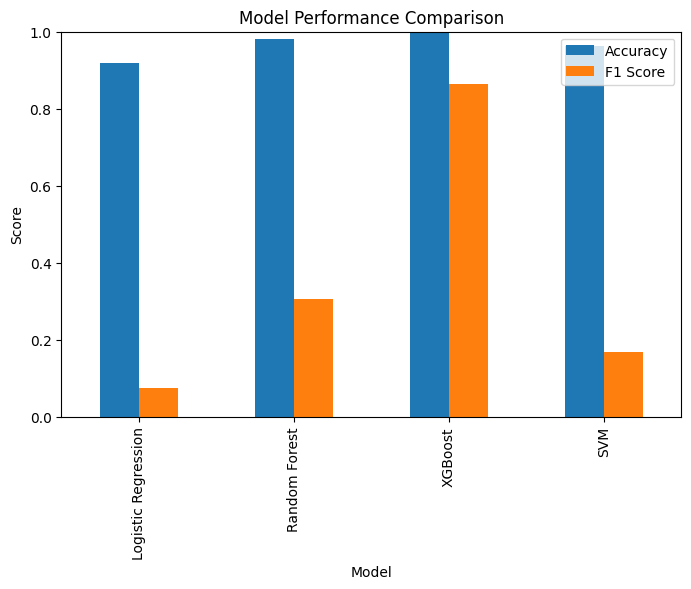

In [77]:
# Plot Accuracy and F1
comparison_df.plot(x="Model", y=["Accuracy", "F1 Score"], kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


### **Best Model based on F1 Score**

In [79]:
best_model_row = comparison_df.loc[comparison_df["F1 Score"].idxmax()]
best_model_name = best_model_row["Model"]

print("Best Model:", best_model_name)
print("Accuracy:", best_model_row["Accuracy"])
print("F1 Score:", best_model_row["F1 Score"])


Best Model: XGBoost
Accuracy: 0.9987145496906885
F1 Score: 0.864406779661017
